In [1]:
import chainer as ch
#import numpy as np

ch.config.debug = True

In [2]:
print(ch.print_runtime_info())

Platform: Linux-5.4.0-81-generic-x86_64-with-Ubuntu-18.04-bionic
Chainer: 7.8.0
ChainerX: Not Available
NumPy: 1.19.5
CuPy:
  CuPy Version          : 7.8.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10010
  CUDA Driver Version   : 11010
  CUDA Runtime Version  : 10010
  cuBLAS Version        : 10201
  cuFFT Version         : 10101
  cuRAND Version        : 10101
  cuSOLVER Version      : (10, 2, 0)
  cuSPARSE Version      : 10300
  NVRTC Version         : (10, 1)
  cuDNN Build Version   : 7605
  cuDNN Version         : 7605
  NCCL Build Version    : 2708
  NCCL Runtime Version  : 2708
  CUB Version           : None
  cuTENSOR Version      : None
iDeep: Not Available
None


In [3]:
import requests
import time
import datetime
from tqdm.notebook import tqdm
import re
import numpy as np
import pandas as pd
import seaborn as sns; sns.set() # sns.set() ==> グラフの見た目をseabornに合わせる
from collections import Counter
from sklearn import preprocessing
import pickle

from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score

import matplotlib.pyplot as plt
%matplotlib inline

# フォントの指定
plt.rcParams['font.family'] = 'IPAexGothic'

Duplicate key in file PosixPath('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/matplotlibrc'), line 758 ('font.family : IPAexGothic')


In [4]:
df_train_dart = pd.read_csv('data/forChainer_dart.csv')
df_train_dart = df_train_dart.drop(columns='Unnamed: 0')
df_train_tarf = pd.read_csv('data/forChainer_tarf.csv')
df_train_tarf = df_train_tarf.drop(columns='Unnamed: 0')

In [5]:
df_train_dart = df_train_dart[['target_rank', 'class_code', 'distance', 'adjustment_time', 'horse_age', 'horse_wakunumber', 'tansho_supporter', 'last_3F', ]]

In [6]:
df_train_dart.head()

,target_rank,class_code,distance,adjustment_time,horse_age,horse_wakunumber,tansho_supporter,last_3F
0,0,7,1000,70,3,1,7.34,38.6
1,10,7,1000,88,3,2,10.00,37.3
2,0,7,1000,73,3,3,18.60,38.8
3,0,7,1000,76,3,4,0.55,37.3
4,0,7,1000,80,3,5,3.17,37.5


In [7]:
df_train_tarf.head()

,年,race_id,day_by_day,target_rank,class_code,distance,adjustment_time,horse_wakunumber,PCI,RPCI,...,corner_rank4,father_name_i,tansho_supporter,pops_pattern,jocky_code,home_ground_chiho,home_ground_ritto,home_ground_miho,horse_weight,last_3F
0,15,2015080101010101,20150801,0,7,1500,72,1,47.1,47.3,...,8,411,5.44,32104,1109,0,0,1,476.0,37.0
1,15,2015080101010101,20150801,10,7,1500,86,2,48.6,47.3,...,4,474,10.96,32104,1025,0,0,1,466.0,36.1
2,15,2015080101010101,20150801,0,7,1500,50,3,38.9,47.3,...,6,657,0.89,32104,1104,0,0,0,470.0,39.9
3,15,2015080101010101,20150801,0,7,1500,61,4,43.5,47.3,...,8,345,0.56,32104,1091,0,0,1,422.0,38.3
4,15,2015080101010101,20150801,0,7,1500,54,5,43.9,47.3,...,10,698,0.34,32104,1085,0,0,1,410.0,38.5


In [8]:
X_train_all_dart = df_train_dart.drop(['target_rank'], axis=1).astype('float32')
y_train_all_dart = df_train_dart['target_rank'].astype('int32')
#X_train_all_tarf = df_train_tarf.drop(['target_rank'], axis=1)
#y_train_all_tarf = df_train_tarf['target_rank']

In [9]:
X_train_all_dart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143072 entries, 0 to 143071
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   class_code        143072 non-null  float32
 1   distance          143072 non-null  float32
 2   adjustment_time   143072 non-null  float32
 3   horse_age         143072 non-null  float32
 4   horse_wakunumber  143072 non-null  float32
 5   tansho_supporter  143072 non-null  float32
 6   last_3F           143072 non-null  float32
dtypes: float32(7)
memory usage: 3.8 MB


In [10]:
def change_fig(x):
    if x is 10:
        return 0
    elif x is 5:
        return 1
    elif x is 3:
        return 2
    else:
        return 3
    

y_train_all_dart = y_train_all_dart.apply(lambda x: change_fig(x))

In [11]:
#y_train_all_dart.unique()
y_train_all_dart.value_counts()

3    113235
0      9955
1      9946
2      9936
Name: target_rank, dtype: int64

In [12]:
# データセットを分割するモジュールの読み込み
from sklearn.model_selection import train_test_split

x_train_val, t_train_val, x_test, t_test = train_test_split(X_train_all_dart, y_train_all_dart, test_size=0.3, random_state=0)
x_train, x_val, t_train, t_val = train_test_split(x_train_val, x_test, test_size=0.3, random_state=0)

In [13]:
print('x_train => ', x_train.shape) # 訓練データ
print('t_train => ', t_train.shape)
print('t_train_val => ', t_train_val.shape) # 確認データ
print('t_test => ', t_test.shape)
print('x_val => ', x_val.shape) # 検証データ
print('t_val => ', t_val.shape)

x_train =>  (70105, 7)
t_train =>  (70105,)
t_train_val =>  (42922, 7)
t_test =>  (42922,)
x_val =>  (30045, 7)
t_val =>  (30045,)


In [14]:
y_train_all_dart

0         3
1         0
2         3
3         3
4         3
         ..
143067    1
143068    3
143069    3
143070    3
143071    3
Name: target_rank, Length: 143072, dtype: int64

class 1 =>  4918
class 2 =>  4786
class 3 =>  55528
class 4 =>  0


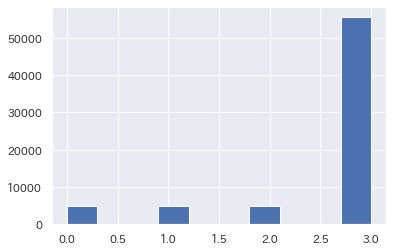

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.hist(t_train)
print('class 1 => ', np.sum(t_train==1))
print('class 2 => ', np.sum(t_train==2))
print('class 3 => ', np.sum(t_train==3))
print('class 4 => ', np.sum(t_train==4))

In [16]:
x_train_val.columns

Index(['class_code', 'distance', 'adjustment_time', 'horse_age',
       'horse_wakunumber', 'tansho_supporter', 'last_3F'],
      dtype='object')

In [17]:
# 正則化(過学習防止のため罰則を設ける)
from sklearn import preprocessing

mmscaler = preprocessing.MinMaxScaler()
mmscaler.fit(x_train_val)
x_train_val_mms = pd.DataFrame(mmscaler.transform(x_train_val))

x_train_val_mms.describe()


,0,1,2,3,4,5,6
count,100150.000000,100150.000000,100150.000000,100150.000000,100150.000000,100150.000000,100150.000000
mean,0.095575,0.357264,0.615425,0.180181,0.527252,0.094670,0.333854
std,0.146403,0.193805,0.134285,0.138464,0.322682,0.129357,0.121162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.133333,0.544715,0.111111,0.285714,0.012388,0.250000
50%,0.085106,0.400000,0.634146,0.111111,0.571429,0.041432,0.319444
75%,0.085106,0.533333,0.707317,0.222222,0.857143,0.125533,0.402778
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# スケール変換によって変わってしまった列名を戻す
x_train_val = x_train_val_mms.rename(columns={
    0:'class_code',
    1:'distance',
    2:'adjustment_time',
    3:'horse_age',
    4:'horse_wakunumber',
    5:'tansho_supporter',
    6:'last_3F'
#    0:'年',
#    1:'race_id',
#    2:'day_by_day',
#    3:'class_code',
#   4:'distance',
#    5:'adjustment_time',
#    6:'horse_wakunumber',
#   7:'PCI',
#    8:'RPCI',
#    9:'PCI3',
#    10:'horse_age',
#    11:'weight_condition',
#   12:'only_female_race',
#    13:'main_prace',
#    14:'prace_clockwise',
#    15:'prace_code',
#    16:'jocky_weight',
#    17:'jocky_ranking',
#    18:'jocky_outsider',
#    19:'jocky_three_up',
#    20:'trainer_rancking',
#    21:'trainer_outsider',
#    22:'trainer_three_up',
#    23:'baba_i',
#    24:'where_i',
#    25:'sex_i',
#    26:'baba_condition_i',
#    27:'horse_gear_d',
#    28:'corner_rank3',
#    29:'corner_rank4',
#    30:'father_name_i',
#    31:'tansho_supporter',
#    32:'pops_pattern',
#    33:'jocky_code',
#    34:'home_ground_chiho',
#    35:'home_ground_ritto',
#    36:'home_ground_miho',
#    37:'horse_weight',
#    38:'last_3F'
})
x_train_val.head()

,class_code,distance,adjustment_time,horse_age,horse_wakunumber,tansho_supporter,last_3F
0,0.042553,0.400000,0.373984,0.000000,0.571429,0.051617,0.416667
1,0.191489,0.533333,0.691057,0.444444,1.000000,0.110117,0.402778
2,0.000000,0.133333,0.504065,0.111111,0.142857,0.188713,0.423611
3,0.191489,0.933333,0.642276,0.555556,0.428571,0.004542,0.312500
4,0.085106,0.000000,0.658537,0.111111,1.000000,0.170957,0.111111


In [19]:
mmscaler = preprocessing.MinMaxScaler()
mmscaler.fit(t_train_val)
t_train_val_mms = pd.DataFrame(mmscaler.transform(t_train_val))

t_train_val_mms.describe()

# スケール変換によって変わってしまった列名を戻す
t_train_val = t_train_val_mms.rename(columns={
    0:'class_code',
    1:'distance',
    2:'adjustment_time',
    3:'horse_age',
    4:'horse_wakunumber',
    5:'tansho_supporter',
    6:'last_3F'
#    0:'年',
#    1:'race_id',
#    2:'day_by_day',
#    3:'class_code',
#   4:'distance',
#    5:'adjustment_time',
#    6:'horse_wakunumber',
#   7:'PCI',
#    8:'RPCI',
#    9:'PCI3',
#    10:'horse_age',
#    11:'weight_condition',
#   12:'only_female_race',
#    13:'main_prace',
#    14:'prace_clockwise',
#    15:'prace_code',
#    16:'jocky_weight',
#    17:'jocky_ranking',
#    18:'jocky_outsider',
#    19:'jocky_three_up',
#    20:'trainer_rancking',
#    21:'trainer_outsider',
#    22:'trainer_three_up',
#    23:'baba_i',
#    24:'where_i',
#    25:'sex_i',
#    26:'baba_condition_i',
#    27:'horse_gear_d',
#    28:'corner_rank3',
#    29:'corner_rank4',
#    30:'father_name_i',
#    31:'tansho_supporter',
#    32:'pops_pattern',
#    33:'jocky_code',
#    34:'home_ground_chiho',
#    35:'home_ground_ritto',
#    36:'home_ground_miho',
#    37:'horse_weight',
#    38:'last_3F'
})
t_train_val.head()

,class_code,distance,adjustment_time,horse_age,horse_wakunumber,tansho_supporter,last_3F
0,0.085106,0.266667,0.715447,0.222222,0.857143,0.128184,0.226950
1,0.085106,0.533333,0.658537,0.111111,0.142857,0.060856,0.276596
2,0.191489,0.533333,0.487805,0.222222,0.714286,0.067878,0.482269
3,0.191489,0.266667,0.691057,0.333333,0.857143,0.151590,0.326241
4,0.085106,0.133333,0.707317,0.111111,0.142857,0.007160,0.191489


In [20]:
import chainer
from chainer import datasets, iterators
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

chainer.config.debug = True

In [21]:
from chainer.datasets import TupleDataset

# 入力値と目標値を引数に与え、`TupleDataset` オブジェクトを作成
dataset = TupleDataset(np.array(x_train_val), np.array(x_test))
test = TupleDataset(np.array(t_train_val), np.array(t_test))

from chainer.datasets import split_dataset_random

n_train = int(len(dataset) * 0.75)
#n_valid = int(len(dataset) * 0.2)

train, valid = split_dataset_random(dataset, n_train, seed=0)
#valid, test = split_dataset_random(valid_test, n_valid, seed=0)

print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))
print('Test dataset size:', len(test))

Training dataset size: 75112
Validation dataset size: 25038
Test dataset size: 42922


In [22]:
batchsize = 1
train_iter = iterators.SerialIterator(train, batch_size=batchsize, shuffle=True)
valid_iter = iterators.SerialIterator(valid, batch_size=batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [23]:
class DNN(Chain):
    def __init__(self, n_mid_units=7, n_out=4):
        super(DNN, self).__init__()
        #super().__init__()
        
        with self.init_scope():
            #self.l1 = L.Linear(None, n_mid_units)
            #self.l2 = L.Linear(n_mid_units, n_mid_units)
            #self.l3 = L.Linear(n_mid_units, n_mid_units)
            #self.l4 = L.Linear(n_mid_units, n_out)
            
            # swish
            self.l1 = L.Linear(None, n_mid_units)
            self.s1 = L.Swish(None)
            self.l2 = L.Linear(None, n_mid_units)
            self.s2 = L.Swish(None)
            self.l3 = L.Linear(None, n_out)
 
    def __call__(self, x):
        #h1 = F.selu(self.l1(x))
        #h2 = F.selu(self.l2(h1))
        #h3 = F.selu(self.l3(h2))
        #h1 = F.relu(self.l1(x))
        #h2 = F.relu(self.l2(h1))
        #h3 = F.relu(self.l3(h2))
        #y = self.l4(h3)
        # swish
        h1 = self.s1(self.l1(x))
        h2 = self.s2(self.l2(h1))
        y = self.l3(h2)
        return y

In [24]:
gpu_id = 0
model = DNN()
    
model_loss = L.Classifier(model)

if gpu_id >= 0:
    model_loss.to_gpu(gpu_id)

optimizer = optimizers.SGD()
#optimizer = optimizers.Adam()
#optimizer = optimizers.MomentumSGD(lr=0.1)
optimizer.setup(model_loss)

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

In [25]:
from chainer.training import extensions as E

n_epoch = 30

# トレーナーのセットアップ
trainer = chainer.training.Trainer(
    updater, (n_epoch, 'epoch'), out='result', extensions=[
        E.Evaluator(valid_iter, model_loss, device=gpu_id),
        E.dump_graph('main/loss'),
        E.LogReport(),
        E.PlotReport(['main/loss', 'validation/main/loss'],'epoch', file_name='loss.png'),
        E.PlotReport(['main/accuracy', 'validation/main/accuracy'],'epoch', file_name='accuracy.png'),
        E.PrintReport(['epoch', 'main/loss', 'validation/main/loss',
                       'main/accuracy', 'validation/main/accuracy', 'elapsed_time'])
    ]
)

In [26]:
%%time

trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.501494    0.427123              0.817499       0.833613                  719.734       
2           0.429205    0.424505              0.831385       0.830338                  1393.51       
3           0.41287     0.405245              0.835566       0.836648                  2116.5        
4           0.406389    0.398051              0.837389       0.839684                  2831.82       
5           0.402372    0.406222              0.838987       0.838246                  3589.87       
6           0.399583    0.380667              0.83948        0.844636                  4317.34       
7           0.397914    0.382245              0.840212       0.843797                  5016.94       
8           0.396131    0.384245              0.840758       0.842679                  5680.35       
9           0.394979    0.408324              0.840358       0.837247               